<a href="https://colab.research.google.com/github/Simmetria0/data/blob/master/anomaliesDemo__test_idbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# ** Notification system AI module IdBox**


@Deduce DS
2023

Author: Simmetria0

---


In [43]:
#======
#Import Libraries
#======
import numpy as np
import pandas as pd
import datetime


In [44]:
#===============
#simulate data
#============

date_rng = pd.date_range(start='2022-01-01', end='2022-12-31', freq='H') # hourly data
print(date_rng.shape)
date_rng_new = date_rng[:8736]
print(date_rng_new.shape)

(8737,)
(8736,)


In [65]:
# assume electricity consumption follows a sinusoidal pattern over a day (higher during daytime, lower at nighttime) with some random noise.

daily_pattern = np.sin(np.linspace(-np.pi, np.pi, 24))
consumption = np.tile(daily_pattern, len(date_rng)//24) * 50 + 500 # multiply and add to adjust amplitude and baseline
print(consumption.shape)
consumption += np.random.normal(0, 4, size=len(date_rng_new)) # add some noise


(8736,)


In [70]:
#introduce ANOMALIES
#simulate spikes in eletrcity consumption

n_anomalies = 60
anomaly_indices = np.random.choice(len(date_rng_new), size=n_anomalies, replace=False)
consumption[anomaly_indices] += np.random.uniform(50, 100, size=n_anomalies)



In [71]:
# create dataframe

df = pd.DataFrame(date_rng_new, columns=['date'])
df['consumption'] = consumption
df.set_index('date', inplace=True)

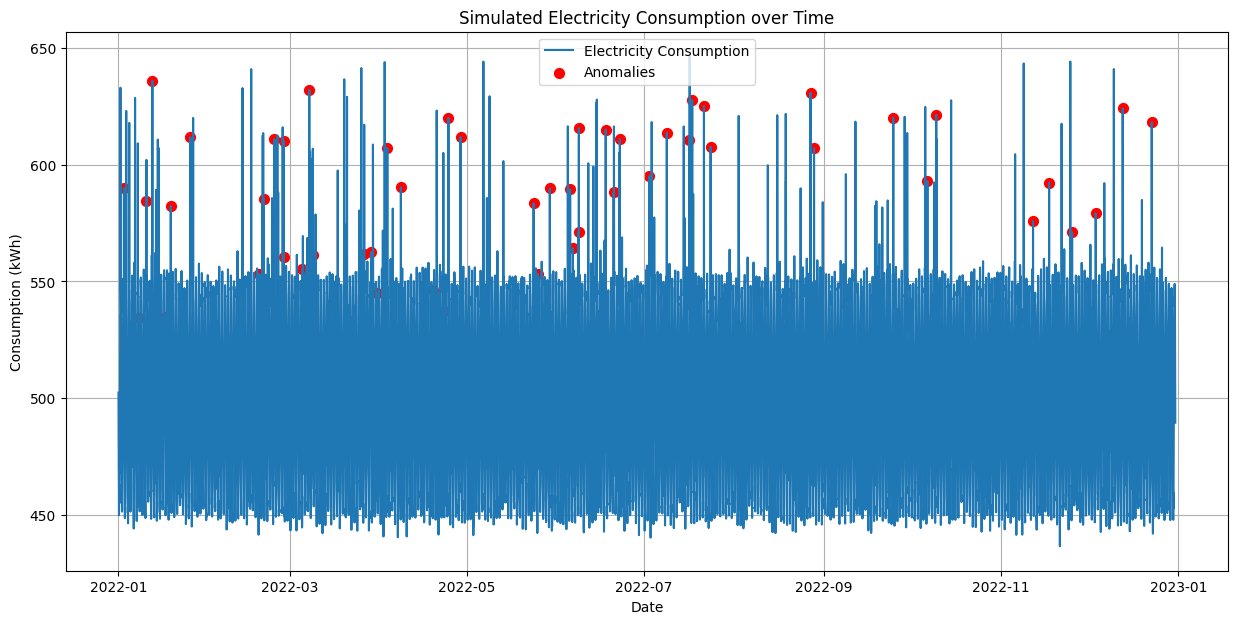

In [72]:
#visuaize the time series for the whole year

import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(df.index, df['consumption'], label='Electricity Consumption')
plt.scatter(df.index[anomaly_indices], df['consumption'].iloc[anomaly_indices], color='red', s=50, label='Anomalies')
plt.title('Simulated Electricity Consumption over Time')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()


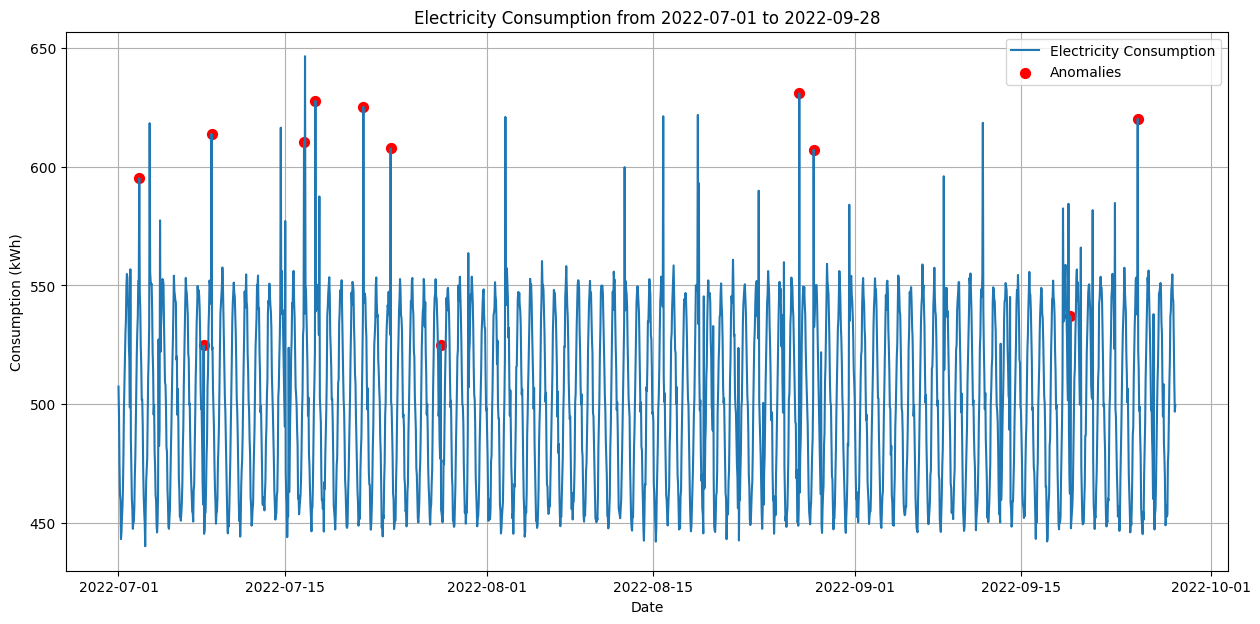

In [75]:
# Filter the data for a period of time
start = '2022-07-01'
end = '2022-09-28'

start_date = pd.Timestamp(start)
end_date = pd.Timestamp(end)
february_data = df.loc[start_date:end_date]

# Filter the anomaly indices for period of time
february_anomaly_indices = [idx for idx in anomaly_indices if start_date <= df.index[idx] <= end_date]

plt.figure(figsize=(15,7))

# Plot February data and anomalies
plt.plot(february_data.index, february_data['consumption'], label='Electricity Consumption')
#plt.scatter(february_data.index[february_anomaly_indices], february_data['consumption'].iloc[february_anomaly_indices], color='red', s=50, label='Anomalies')
plt.scatter(df.index[february_anomaly_indices], df['consumption'].iloc[february_anomaly_indices], color='red', s=50, label='Anomalies')



plt.title(f'Electricity Consumption from {start} to {end}')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()






In [76]:
#====================
#Anomaly detection on PAST data
#==================

import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt


In [35]:
50./df.shape[0]

0.005723443223443223

In [94]:
#Train an isolation forest

# Reshape the data for training
X = df['consumption'].values.reshape(-1, 1)

# Initialize and train the Isolation Forest model
iso_forest = IsolationForest(contamination=0.007, n_estimators = 200)  # Assuming approximately 5% of the data points are anomalies
anomalies = iso_forest.fit_predict(X)


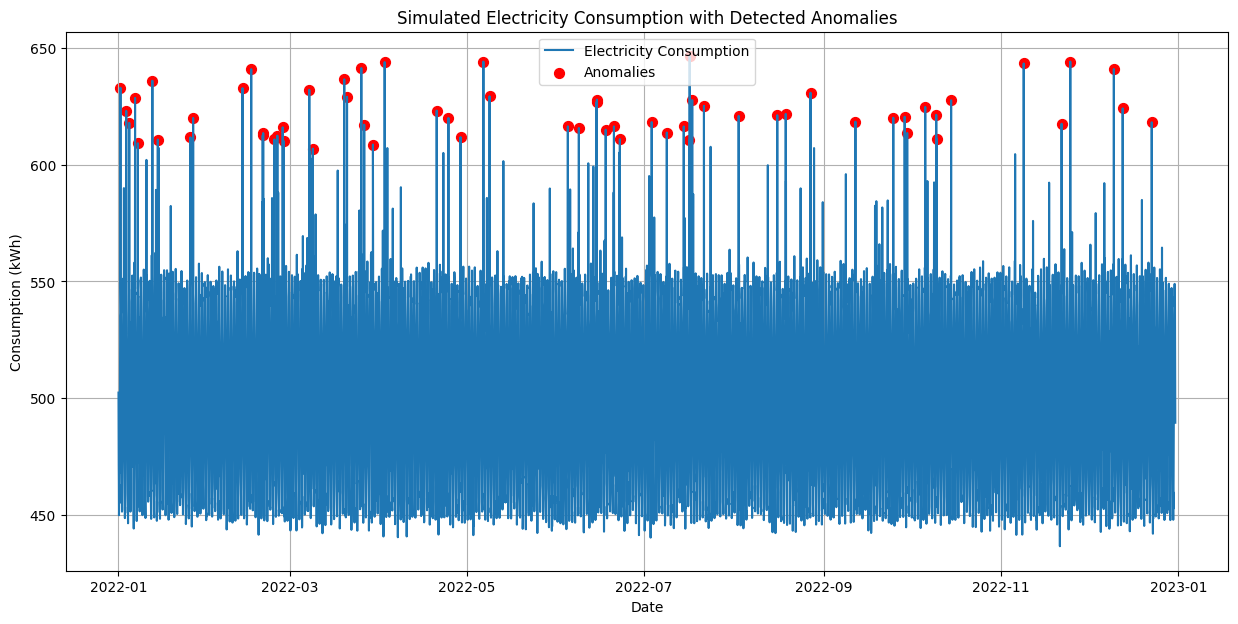

In [95]:
#VISUALIZE

plt.figure(figsize=(15,7))
plt.plot(df.index, df['consumption'], label='Electricity Consumption')

# Highlight anomalies in red
anomaly_indices = np.where(anomalies == -1)[0]
plt.scatter(df.index[anomaly_indices], df['consumption'].iloc[anomaly_indices], color='red', s=50, label='Anomalies')

plt.title('Simulated Electricity Consumption with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()

In [96]:
#RANK anomalies:
anomaly_scores = iso_forest.decision_function(X)


In [97]:
N = 50  # Number of top anomalies you want
top_anomalies_indices = np.argsort(anomaly_scores)[:N]

top_anomalies = df.iloc[top_anomalies_indices]


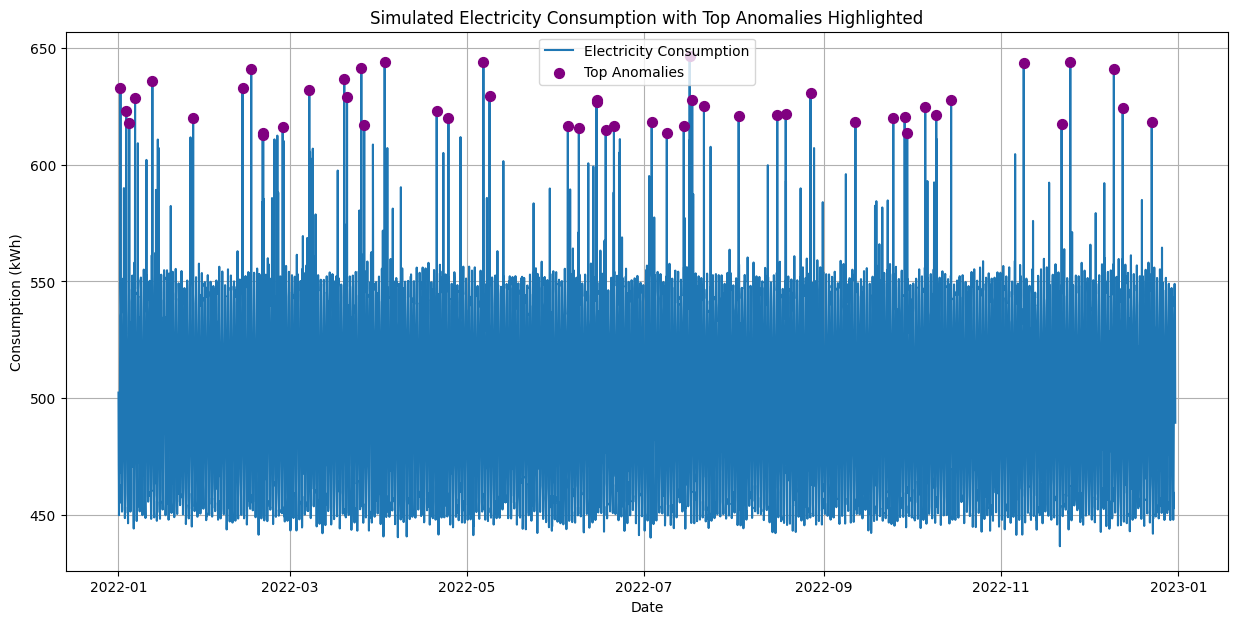

In [98]:
#visualize the most anomalous:
plt.figure(figsize=(15,7))
plt.plot(df.index, df['consumption'], label='Electricity Consumption')

# Highlight the top anomalies in a different color, say purple
plt.scatter(top_anomalies.index, top_anomalies['consumption'], color='purple', s=50, label='Top Anomalies', zorder=5)

plt.title('Simulated Electricity Consumption with Top Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()


-----

Anomaly detection is not limited to just spikes. Anomalies can manifest in various ways, such as:


1.   Spikes: Sudden short-lived peaks or troughs.
2.   Level Changes: A sudden change in the baseline of the data.
3.   Trends: An unexpected drift over a period.
4. Periodic Irregularities: Unexpected changes in a regular pattern (e.g., daily seasonality).
5. Noise: Increased variability in the data.

Here we implemented a simple Isolation Forest algorithm that is a general algorithm that can capture various types of anomalies, but its ability to detect specific types of anomalies can depend on its parameters and the data's characteristics.

For capturing different types of anomalies, we could implement specific approaches.

For example the Z-Score can be employed to detect anomalies based on the distribution and patterns in the data.

---



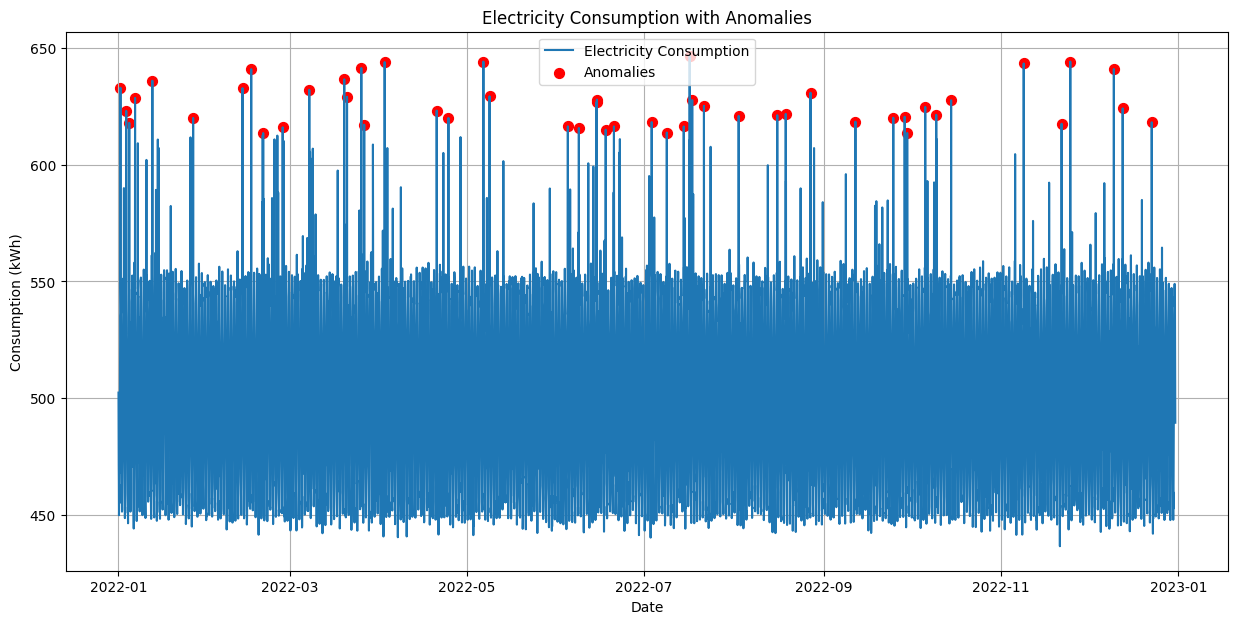

In [104]:
#this method can detect only very anomalous peaks but with more precision

from scipy.stats import zscore

# Calculate z-scores
df['z_score'] = zscore(df['consumption'])

# Define threshold for anomalies, the higher the less
threshold = 3

# Get anomalies
anomalies = df[abs(df['z_score']) > threshold]

# Visualize the data
plt.figure(figsize=(15,7))
plt.plot(df.index, df['consumption'], label='Electricity Consumption')
plt.scatter(anomalies.index, anomalies['consumption'], color='red', s=50, label='Anomalies')
plt.title('Electricity Consumption with Anomalies')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#================================
#describe the anomalies using GPT-2
#===============================
!pip install transformers torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.7 MB/s eta 0:00:00


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

def describe_anomalies(top_anomalies):
    # Initialize GPT-2 medium model
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2-medium")
    model = GPT2LMHeadModel.from_pretrained("gpt2-medium")

    # Construct the prompt
    prompt_text = "During the monitored period, there were several significant anomalies in electricity consumption: "
    for i, (date, consumption) in enumerate(zip(top_anomalies.index, top_anomalies['consumption'])):
        prompt_text += f"On {date.strftime('%Y-%m-%d %H:%M:%S')}, the consumption was {consumption:.2f} kWh. "

    # Encode the text to tensor
    input_ids = tokenizer.encode(prompt_text, return_tensors='pt')

    # Generate an attention mask
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)  # Convert to a tensor of type long

    # Generate description
    output = model.generate(input_ids,
                            attention_mask=attention_mask,
                            pad_token_id=tokenizer.eos_token_id,
                            max_length=500,
                            num_return_sequences=1)

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    return generated_text

# Using the previous top_anomalies DataFrame
description = describe_anomalies(top_anomalies)
print(description)



During the monitored period, there were several significant anomalies in electricity consumption: On 2022-10-24 16:00:00, the consumption was 620.59 kWh. On 2022-05-30 14:00:00, the consumption was 623.85 kWh. On 2022-10-28 13:00:00, the consumption was 606.89 kWh. On 2022-07-18 19:00:00, the consumption was 596.74 kWh. On 2022-03-01 13:00:00, the consumption was 602.45 kWh. On 2022-08-18 20:00:00, the consumption was 594.66 kWh. On 2022-08-12 00:00:00, the consumption was 588.48 kWh. On 2022-11-14 23:00:00, the consumption was 587.12 kWh. On 2022-04-10 17:00:00, the consumption was 563.56 kWh. On 2022-11-03 18:00:00, the consumption was 563.31 kWh. _______________________________________________ Sent through the Full Disclosure mailing list https://nmap.org/mailman/listinfo/fulldisclosure Web Archives & RSS: http://seclists.org/fulldisclosure/ By Date By Thread Current thread: Power Consumption of the Solar PV System on the SolarCity SolarCity SolarCity SolarCity SolarCity SolarCity S

In [ ]:
def structured_description(consumption_data, top_anomalies):
    # Calculate medium consumption over the last month
    last_month = consumption_data.last('1M')
    monthly_avg_consumption = last_month.mean()

    # Average consumption for each day in the last month
    daily_avg_last_month = last_month.resample('D').mean()

    # Find the day with the highest average consumption in the last month
    max_daily_avg_date = daily_avg_last_month.idxmax()
    max_daily_avg_value = daily_avg_last_month.max()

    # Find the most anomalous entry from top_anomalies
    most_anomalous_date = top_anomalies.index[0]
    most_anomalous_value = top_anomalies['consumption'].iloc[0]

    # Construct the description
    description = (f"Your medium consumption over the last month has been {monthly_avg_consumption:.2f} kWh. "
                   f"On {max_daily_avg_date.strftime('%Y-%m-%d')}, the average was {max_daily_avg_value:.2f} kWh. "
                   f"However, on {most_anomalous_date.strftime('%Y-%m-%d')} at {most_anomalous_date.strftime('%H:%M:%S')} "
                   f"we observed a higher consumption of {most_anomalous_value:.2f} kWh.")

    return description



In [ ]:
# Use the function on data
report = structured_description(df['consumption'], top_anomalies)

a="=="*70
print (a)
print(report)
print (a)

Your medium consumption over the last month has been 500.57 kWh. On 2022-12-23, the average was 505.73 kWh. However, on 2022-01-08 at 16:00:00 we observed a higher consumption of 628.95 kWh.


In [ ]:
#==================
# PREDICTIVO
#=======================
from sklearn.ensemble import IsolationForest

# Dividir datos en conjuntos de entrenamiento y prueba
train = df['consumption'].iloc[:int(0.7*len(df))]
test = df['consumption'].iloc[int(0.7*len(df)):]

# Entrenar el modelo
clf = IsolationForest(contamination=0.05)  # el nivel de contaminación es un hiperparámetro que puede necesitar ajuste
clf.fit(train.values.reshape(-1, 1))

# Predicción en el conjunto de prueba
predictions = clf.predict(test.values.reshape(-1, 1))

# Identificar los índices de las anomalías en el conjunto de prueba
anomaly_indices = test[predictions == -1].index


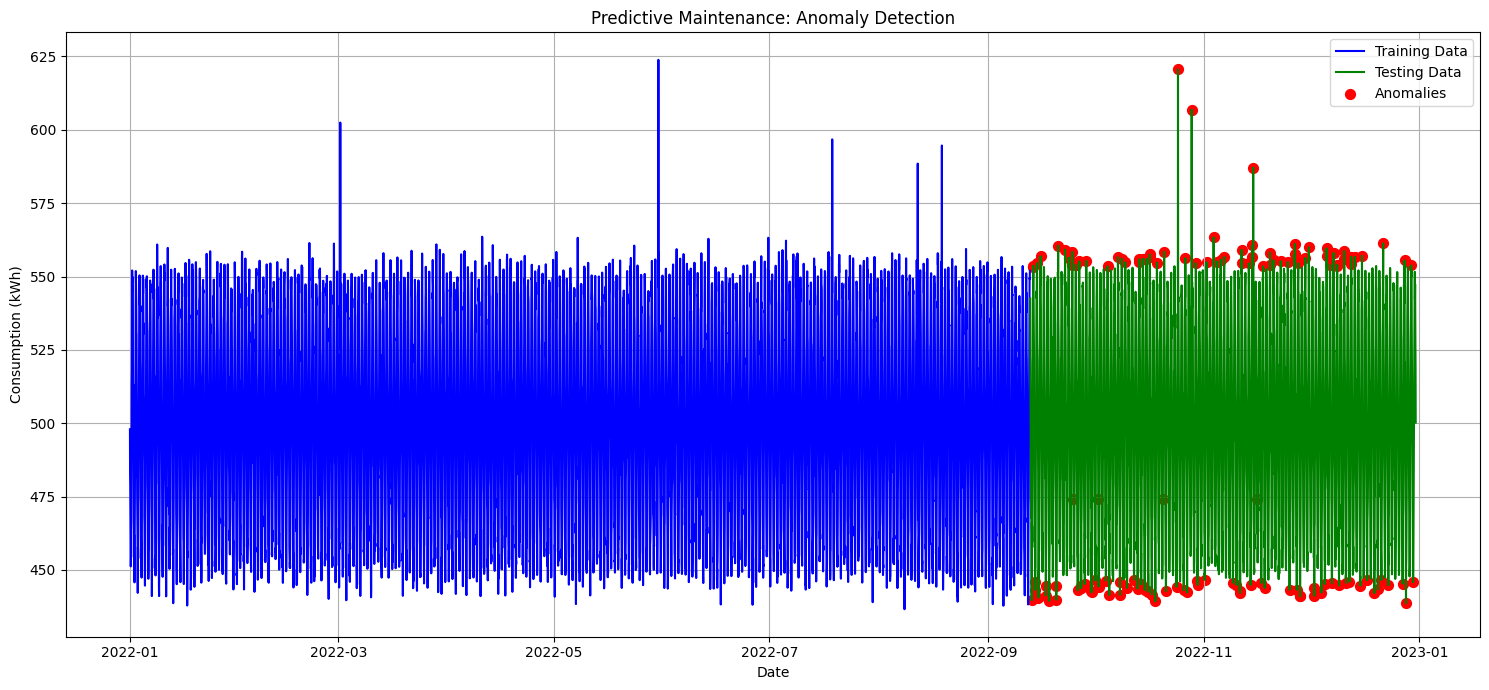

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

# Plotting training data
plt.plot(train.index, train.values, label='Training Data', color='blue')

# Plotting testing data
plt.plot(test.index, test.values, label='Testing Data', color='green')

# Highlighting anomalies in red
plt.scatter(anomaly_indices, test.loc[anomaly_indices].values, color='red', s=50, label='Anomalies')

plt.title('Predictive Maintenance: Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [107]:
#====
#Creamos otro set de datos donde anomalia es tambien cambio de tendencia
#=====

#creamos dataset
import numpy as np
import pandas as pd

# Generar serie temporal
date_rng = pd.date_range(start='2022-01-01', end='2022-12-31', freq='H') # hourly data
date_rng_new = date_rng[:8736]

daily_pattern = np.sin(np.linspace(-np.pi, np.pi, 24))
consumption = np.tile(daily_pattern, len(date_rng)//24) * 50 + 500 # adjust amplitude and baseline
consumption += np.random.normal(0, 5, size=len(date_rng_new)) # add some noise

# Introducir picos y caídas como anomalías
for _ in range(150):  # 150 picos
    consumption[np.random.randint(0, len(consumption))] += np.random.randint(30, 50)
for _ in range(150):  # 150 caídas
    consumption[np.random.randint(0, len(consumption))] -= np.random.randint(30, 50)

df = pd.DataFrame(consumption, index=date_rng_new, columns=['consumption'])



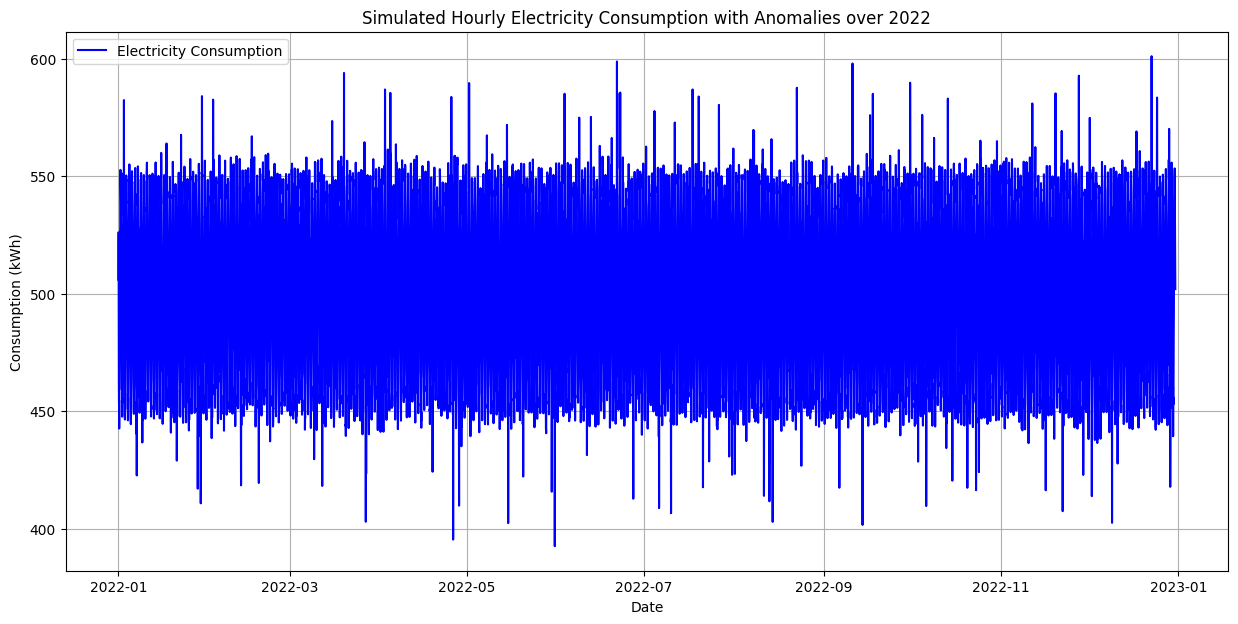

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(df.index, df['consumption'], label='Electricity Consumption', color='blue')
plt.title('Simulated Hourly Electricity Consumption with Anomalies over 2022')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()



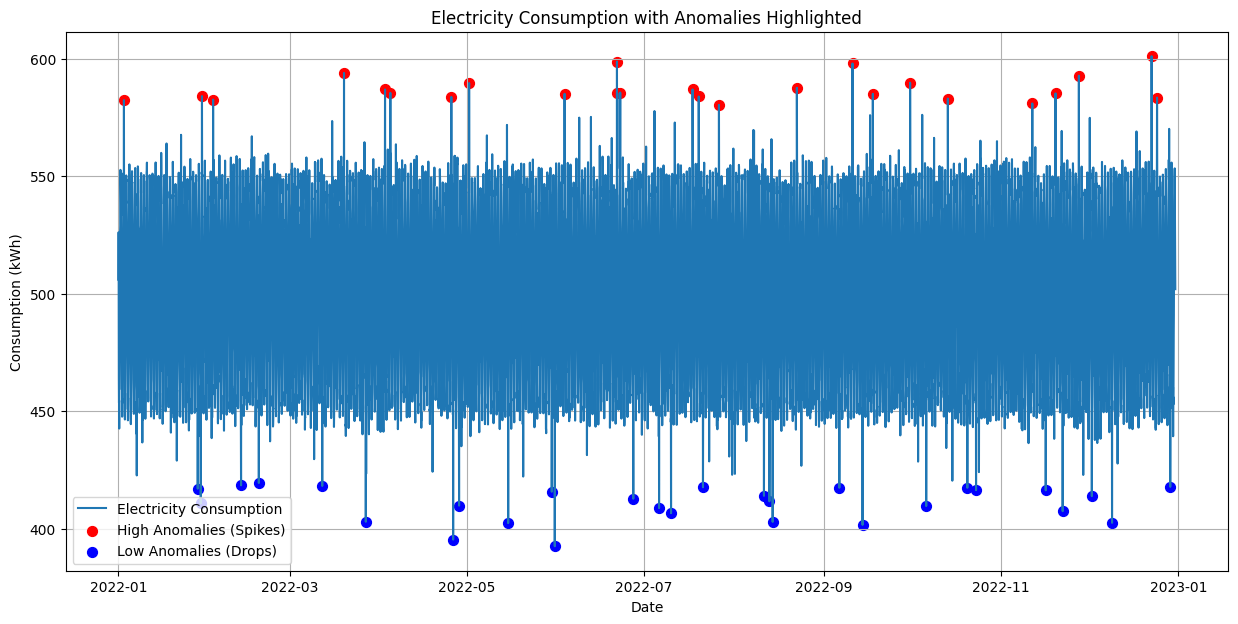

In [ ]:
import matplotlib.pyplot as plt

# Identificar las anomalías
anomaly_threshold_high = df['consumption'].mean() + 80 # Asumimos que un consumo 30 unidades por encima del promedio es una anomalía
anomaly_threshold_low = df['consumption'].mean() - 80 # Asumimos que un consumo 30 unidades por debajo del promedio es una anomalía

# Obtener índices de las anomalías
anomalies_high = df[df['consumption'] > anomaly_threshold_high]
anomalies_low = df[df['consumption'] < anomaly_threshold_low]

plt.figure(figsize=(15,7))

# Visualizar la serie temporal
plt.plot(df.index, df['consumption'], label='Electricity Consumption')

# Resaltar las anomalías
plt.scatter(anomalies_high.index, anomalies_high['consumption'], color='red', s=50, label='High Anomalies (Spikes)')
plt.scatter(anomalies_low.index, anomalies_low['consumption'], color='blue', s=50, label='Low Anomalies (Drops)')

plt.title('Electricity Consumption with Anomalies Highlighted')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()


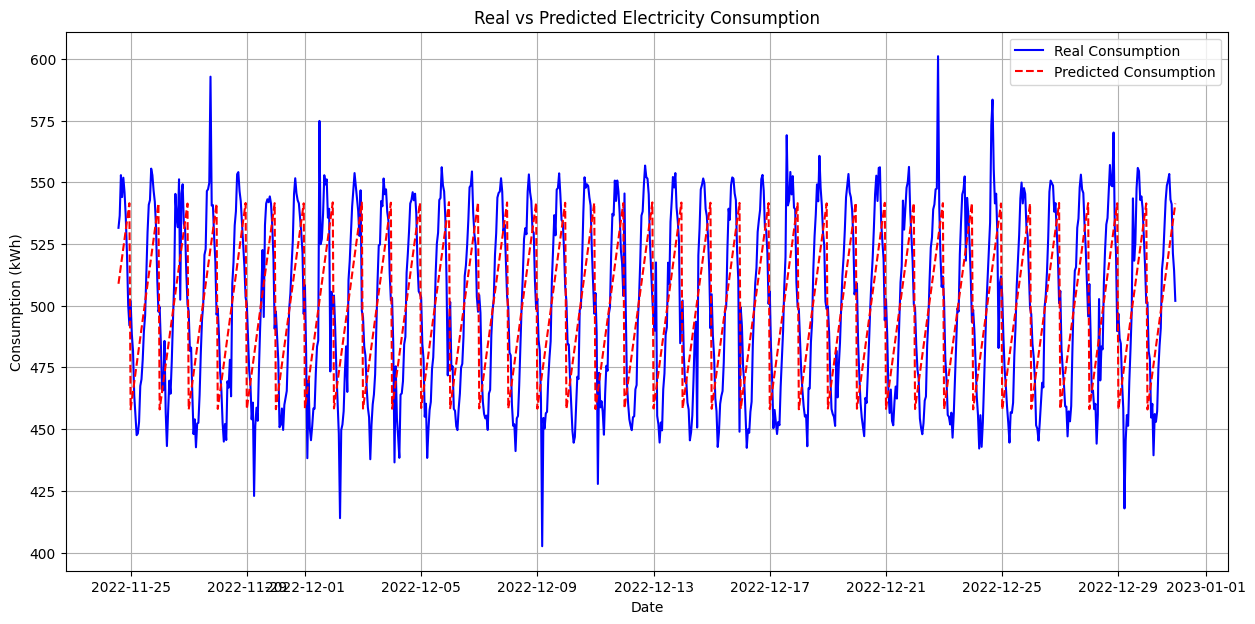

Mean Squared Error: 680.49


In [ ]:
#creamos un predictor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Extraer características temporales
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day

# Dividir el conjunto de datos
X = df[['hour', 'day_of_week', 'day_of_month']]
y = df['consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) # Usamos un 10% para prueba

# Entrenar el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Visualizar predicciones vs valores reales
plt.figure(figsize=(15,7))
plt.plot(y_test.index, y_test, label='Real Consumption', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Consumption', color='red', linestyle='--')
plt.title('Real vs Predicted Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()

# También puedes ver el error cuadrático medio para evaluar la precisión del modelo
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


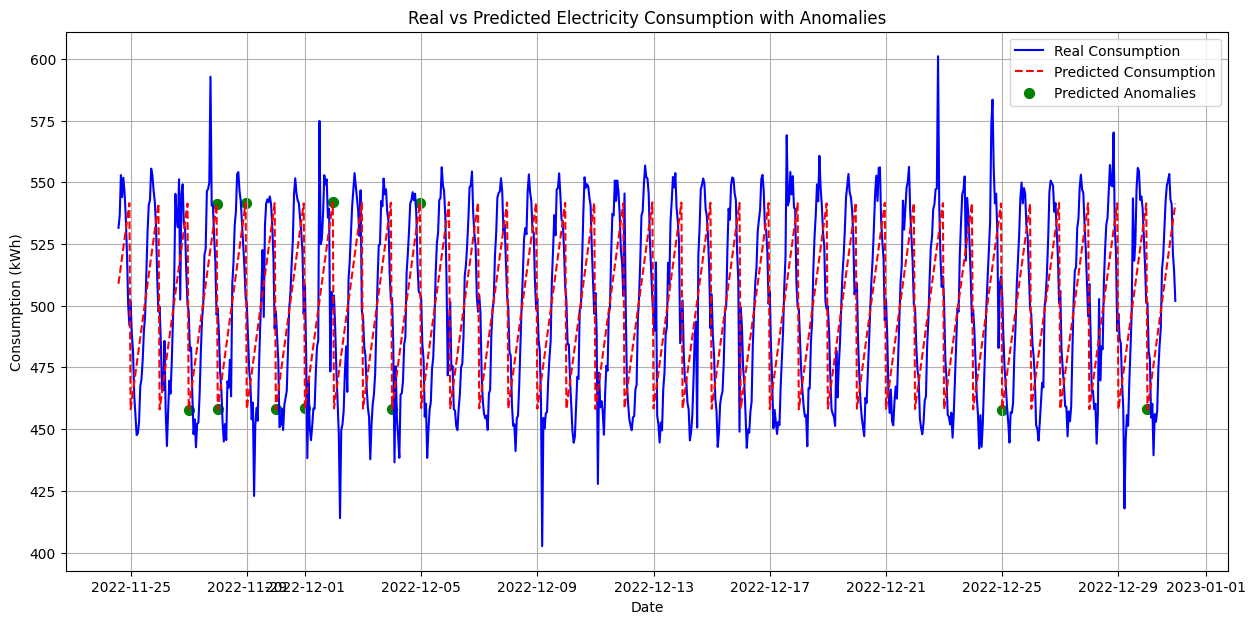

In [ ]:
#apliamos el detector de anomalias al futuro

#same model as before for consistance
from sklearn.ensemble import IsolationForest

# Entrenar el modelo Isolation Forest en los datos originales
iso_forest = IsolationForest(contamination=0.02)
iso_forest.fit(X_train)

# Detectar anomalías en las predicciones
anomalies = iso_forest.predict(X_test)
anomaly_indices = np.where(anomalies == -1)[0]

# Visualizar las predicciones y las anomalías detectadas
plt.figure(figsize=(15,7))
plt.plot(y_test.index, y_test, label='Real Consumption', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Consumption', color='red', linestyle='--')

# Resaltar las anomalías en las predicciones
plt.scatter(y_test.index[anomaly_indices], y_pred[anomaly_indices], color='green', s=50, label='Predicted Anomalies')

plt.title('Real vs Predicted Electricity Consumption with Anomalies')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.legend()
plt.grid(True)
plt.show()



In [108]:
#SIMULA PARADAS de consumo

import numpy as np
import pandas as pd

# Crea un rango de fechas
date_rng = pd.date_range(start='2022-01-01', end='2022-12-31', freq='H')
date_rng_new = date_rng[:8736]

# Crea un patrón de consumo sinusoidal
daily_pattern = np.sin(np.linspace(-np.pi, np.pi, 24))
consumption = np.tile(daily_pattern, len(date_rng)//24) * 50 + 500
consumption += np.random.normal(0, 5, size=len(date_rng_new))

# Introduce interrupciones
n_interruptions = 3
interruption_indices = np.random.choice(len(date_rng_new), size=n_interruptions, replace=False)
interruption_duration = 24  # duración de la interrupción en horas
for idx in interruption_indices:
    consumption[idx:idx+interruption_duration] = 0

# Crea un dataframe
df = pd.DataFrame(date_rng_new, columns=['date'])
df['consumption'] = consumption
df.set_index('date', inplace=True)





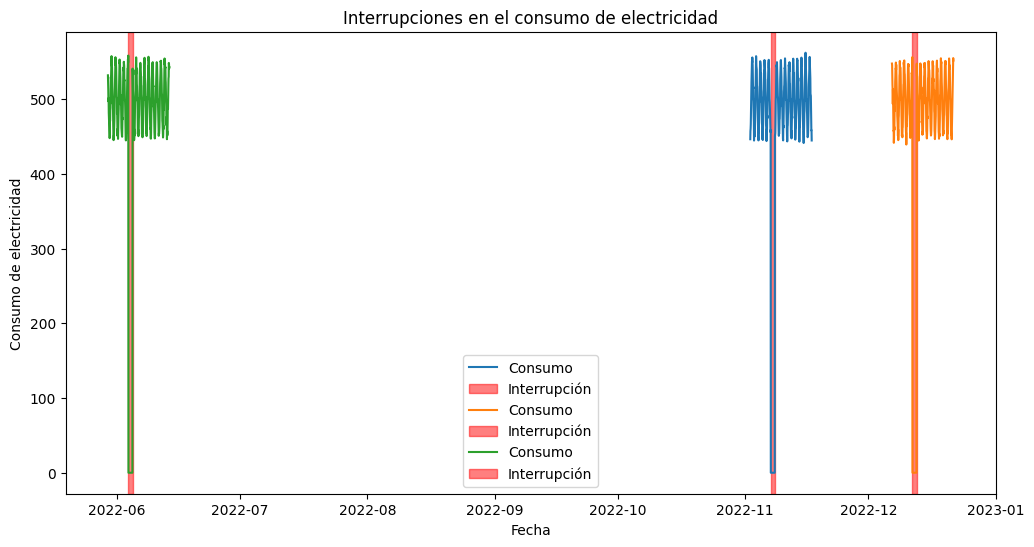

In [110]:
plt.figure(figsize=(12, 6))

for idx in interruption_indices:
    start = max(0, idx - 5*24)  # Comienza 5 días antes de la interrupción
    end = min(len(df), idx + 10*24)  # Termina 5 días después del inicio de la interrupción
    plt.plot(df.index[start:end], df['consumption'][start:end], label='Consumo')

    # Resalta la interrupción
    plt.axvspan(df.index[idx], df.index[min(len(df), idx + interruption_duration)], color='red', alpha=0.5, label='Interrupción')

plt.xlabel('Fecha')
plt.ylabel('Consumo de electricidad')
plt.title('Interrupciones en el consumo de electricidad')
plt.legend()
plt.show()



Epoch 1/20
83/83 - 8s - loss: 0.0316 - 8s/epoch - 92ms/step
Epoch 2/20
83/83 - 5s - loss: 0.0046 - 5s/epoch - 66ms/step
Epoch 3/20
83/83 - 4s - loss: 0.0042 - 4s/epoch - 45ms/step
Epoch 4/20
83/83 - 3s - loss: 0.0035 - 3s/epoch - 39ms/step
Epoch 5/20
83/83 - 2s - loss: 0.0020 - 2s/epoch - 30ms/step
Epoch 6/20
83/83 - 3s - loss: 0.0011 - 3s/epoch - 30ms/step
Epoch 7/20
83/83 - 2s - loss: 9.4938e-04 - 2s/epoch - 30ms/step
Epoch 8/20
83/83 - 4s - loss: 9.4678e-04 - 4s/epoch - 47ms/step
Epoch 9/20
83/83 - 3s - loss: 8.8550e-04 - 3s/epoch - 30ms/step
Epoch 10/20
83/83 - 3s - loss: 8.6883e-04 - 3s/epoch - 31ms/step
Epoch 11/20
83/83 - 2s - loss: 8.4761e-04 - 2s/epoch - 30ms/step
Epoch 12/20
83/83 - 3s - loss: 8.2095e-04 - 3s/epoch - 32ms/step
Epoch 13/20
83/83 - 4s - loss: 8.1229e-04 - 4s/epoch - 46ms/step
Epoch 14/20
83/83 - 2s - loss: 7.6727e-04 - 2s/epoch - 30ms/step
Epoch 15/20
83/83 - 2s - loss: 7.8284e-04 - 2s/epoch - 30ms/step
Epoch 16/20
83/83 - 3s - loss: 7.5411e-04 - 3s/epoch - 30m

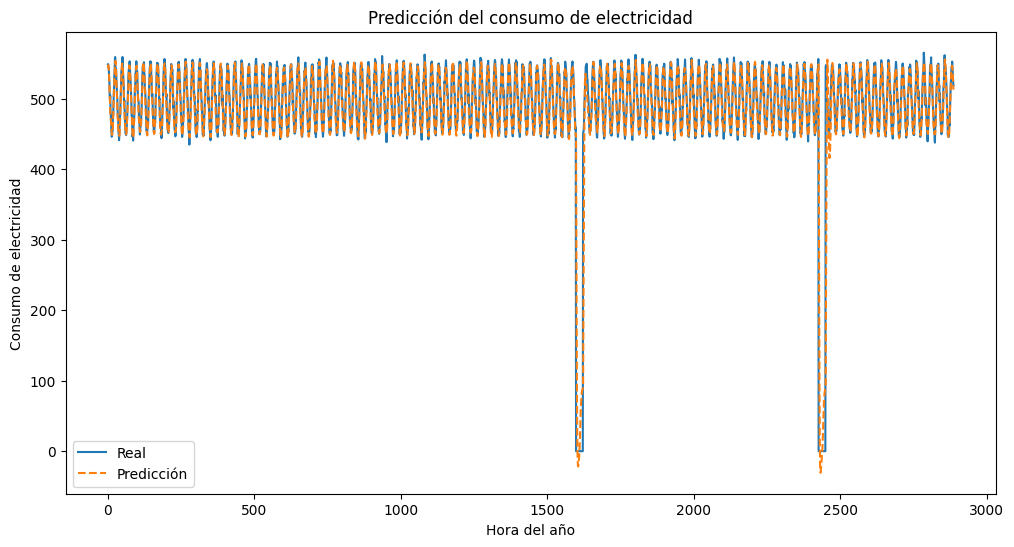

In [112]:
#UN MODELO PREDICTIVO TRAIN on first 8 months, predict on last 4 months, alnaza a predecir interrupciones usando previous 24 hours

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Preparar los datos
data = df['consumption'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Dividir los datos en conjuntos de entrenamiento y prueba (8 meses para entrenamiento, 4 meses para prueba)
train_size = int(len(data) * 8/12)
train, test = data[0:train_size], data[train_size:len(data)]

# Convertir los datos en un formato adecuado para LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 24  # número de horas en el pasado que usará el modelo para hacer predicciones
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Remodelar los datos para ser [muestras, pasos de tiempo, características]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=20, batch_size=70, verbose=2)

# Hacer predicciones
y_pred = model.predict(X_test)

# Invertir la normalización
y_test = scaler.inverse_transform([y_test])
y_pred = scaler.inverse_transform(y_pred)

# Calcular el error cuadrático medio
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test[0], y_pred[:,0])
print(f'Mean Squared Error: {mse:.2f}')

# Graficar los resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test[0], label='Real')
plt.plot(y_pred[:,0], label='Predicción', linestyle='dashed')
plt.xlabel('Hora del año')
plt.ylabel('Consumo de electricidad')
plt.title('Predicción del consumo de electricidad')
plt.legend()
plt.show()



---

El modelo LSTM de arriba está diseñado para predecir el consumo de electricidad basado en los datos históricos, pero no está específicamente diseñado para predecir interrupciones en el suministro de electricidad.  Aunque es bastante accurate qua a corto plazo consigue a predecirlas.

Para predecir interrupciones, se puede diseñar un modelo de clasificación que use característica para predecir la probabilidad de una interrupción en un momento dado.

---


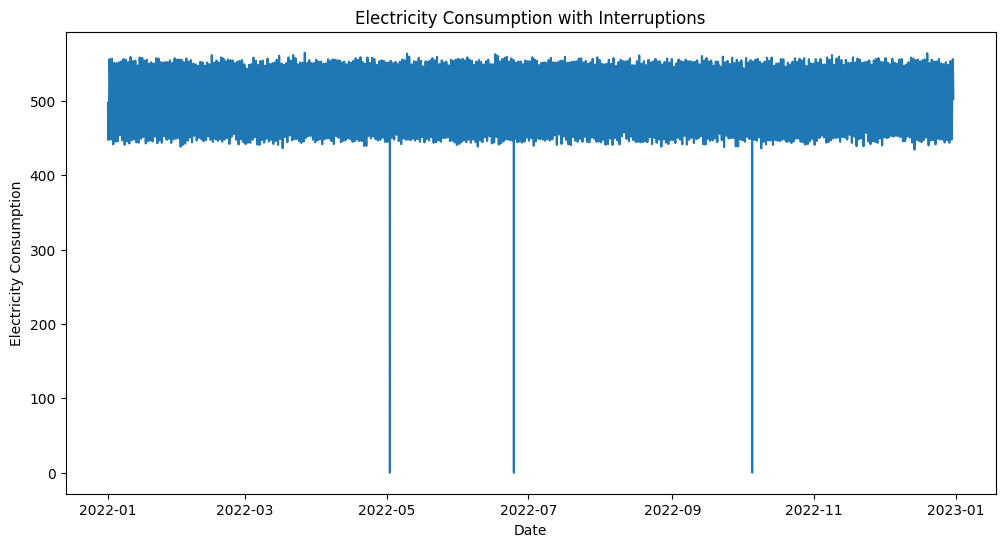

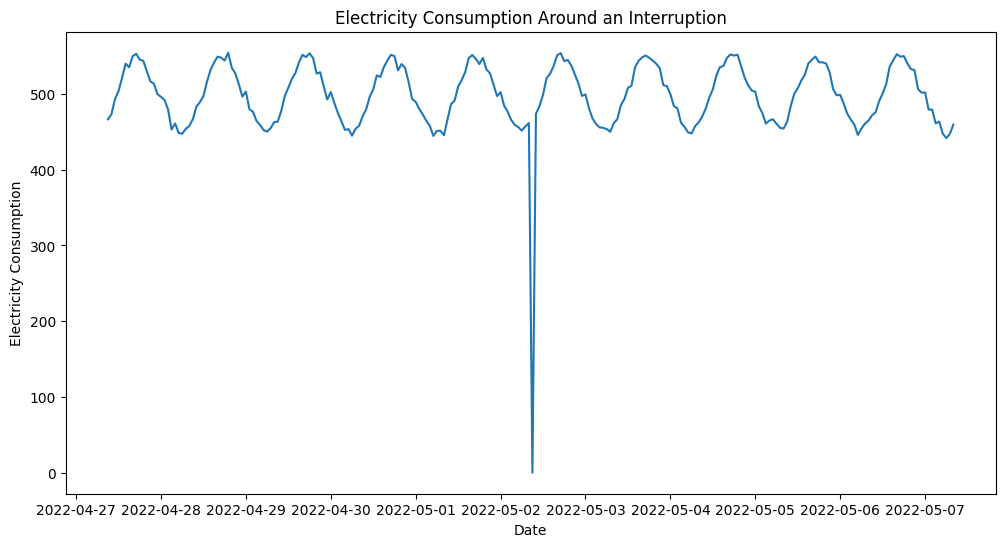

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Crear una serie temporal de un año con frecuencia horaria
date_rng = pd.date_range(start='2022-01-01', end='2022-12-31', freq='H')
date_rng = date_rng[:8736]

# Supongamos que el consumo de electricidad sigue un patrón sinusoidal a lo largo del día (mayor durante el día, menor durante la noche) con algún ruido aleatorio.
daily_pattern = np.sin(np.linspace(-np.pi, np.pi, 24))
consumption = np.tile(daily_pattern, len(date_rng)//24) * 50 + 500
consumption += np.random.normal(0, 5, size=len(date_rng))

# Introduce interrupciones (consumo = 0) en 3 días aleatorios del año
np.random.seed(0)
interruptions = np.random.choice(len(date_rng), size=3, replace=False)
consumption[interruptions] = 0

# Crear un dataframe
df = pd.DataFrame(date_rng, columns=['date'])
df['consumption'] = consumption
df.set_index('date', inplace=True)

# Visualizar los datos
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['consumption'])
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption with Interruptions')
plt.show()

# Visualizar una interrupción
plt.figure(figsize=(12, 6))
plt.plot(df.index[interruptions[0]-5*24:interruptions[0]+5*24], df['consumption'][interruptions[0]-5*24:interruptions[0]+5*24])
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption Around an Interruption')
plt.show()




In [131]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Crear un nuevo dataframe
np.random.seed(0)
df = pd.DataFrame({
    'fecha': pd.date_range(start='2022-01-01', periods=100),
    'consumo': np.random.normal(100, 10, 100),
})

# Simular interrupciones
df.loc[np.random.choice(df.index, size=3), 'consumo'] = 0

# Convertir la fecha en una característica numérica
df['dia_del_año'] = df['fecha'].dt.dayofyear
df.drop('fecha', axis=1, inplace=True)

# Normalizar los datos
# Normalizar solo la columna 'consumo'
scaler = StandardScaler()
df['consumo'] = scaler.fit_transform(df[['consumo']])



# Preparar los datos para el modelo LSTM
X = []
y = []
for i in range(10, len(df)):
    X.append(df_scaled[i-10:i])
    y.append(df_scaled[i, 0])
X, y = np.array(X), np.array(y)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Hacer predicciones
y_pred = model.predict(X_test)

# Transformar las predicciones de vuelta a la escala original
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

# Calcular el error
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)








Epoch 1/100
3/3 [==============================] - 4s 15ms/step - loss: 1.2658
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 1.2503
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 1.2479
Epoch 4/100
3/3 [==============================] - 0s 14ms/step - loss: 1.2486
Epoch 5/100
3/3 [==============================] - 0s 14ms/step - loss: 1.2511
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 1.2493
Epoch 7/100
3/3 [==============================] - 0s 15ms/step - loss: 1.2465
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 1.2406
Epoch 9/100
3/3 [==============================] - 0s 15ms/step - loss: 1.2373
Epoch 10/100
3/3 [==============================] - 0s 16ms/step - loss: 1.2312
Epoch 11/100
3/3 [==============================] - 0s 14ms/step - loss: 1.2252
Epoch 12/100
3/3 [==============================] - 0s 14ms/step - loss: 1.2229
Epoch 13/100
3/3 [==============================]

In [138]:
# Hacer predicciones
y_pred = model.predict(X_train)




3/3 [==============================] - 0s 7ms/step


In [143]:
y_train

array([ 0.03929432, -0.12816922, -4.93079488,  0.88653313,  0.19563722,
       -0.19068303, -0.07369696,  0.22015508, -0.64715925,  0.66403105,
        0.23576814,  0.19193859,  0.70702501, -4.93079488,  0.73889972,
        0.90611986, -0.20998543, -0.0516183 ,  0.88358406,  0.15664737,
       -0.07299042,  0.35500294, -0.60571954,  0.03562042, -0.32285221,
       -0.6864612 ,  0.29923466,  0.74905503, -0.02732445,  0.20325965,
       -0.1275857 , -0.06567497,  0.46116331, -0.09135904, -0.87215417,
       -0.28118867, -1.16174991, -0.58833563, -4.93079488,  0.36457814,
        0.58627898,  0.86638693, -0.73321225,  0.72695526,  1.27911431,
        0.48796443,  0.87402181, -0.022643  , -0.0532318 ,  1.0342132 ,
        0.19458915,  0.15878315,  0.20877826,  0.31071946,  0.36603585,
        0.2094876 ,  0.52385669,  0.16402239,  0.02268593, -0.21623577,
       -0.32884047,  0.56786131, -0.45934302, -0.50370175,  0.32175081,
        0.62464887, -0.30191381,  0.13567123, -0.16260759,  0.33